In [28]:
# Setup & Imports
import sys
import os
sys.path.append(os.path.abspath(".."))

import pandas as pd
import joblib
import ipywidgets as widgets
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, clear_output, Markdown
from utils.preprocessing import preprocess_features

model = joblib.load("../model/model/readmission_rf_model.pkl")

In [ ]:
# Title & Instructions

display(Markdown("""
# 30-Day Readmission Risk Prediction
Welcome to the patient risk prediction tool.
Fill out the patient's details below and click **Predict Risk** to estimate their 30-day readmission likelihood.
"""))

In [35]:
# Define Input Widgets
age = widgets.IntSlider(value=65, min=18, max=100, description='Age:', layout=widgets.Layout(width='90%'))
gender = widgets.Dropdown(options=['Male', 'Female'], description='Gender:', layout=widgets.Layout(width='90%'))
primary_diagnosis = widgets.Dropdown(
    options=['Heart Disease', 'COPD', 'Diabetes', 'Kidney Disease'],
    description='Diagnosis:', layout=widgets.Layout(width='90%')
)
num_procedures = widgets.IntSlider(min=0, max=10, description='Procedures:', layout=widgets.Layout(width='90%'))
days_in_hospital = widgets.IntSlider(min=1, max=20, description='Days:', layout=widgets.Layout(width='90%'))
comorbidity_score = widgets.IntSlider(min=0, max=4, description='Comorbidity:', layout=widgets.Layout(width='90%'))
discharge_to = widgets.Dropdown(
    options=['Home', 'Home Health Care', 'Rehabilitation Facility', 'Skilled Nursing Facility'],
    description='Discharge:', layout=widgets.Layout(width='90%')
)

In [ ]:
# Arrange Widgets in a VBox Form
form = widgets.VBox([
    age,
    gender,
    primary_diagnosis,
    num_procedures,
    days_in_hospital,
    comorbidity_score,
    discharge_to
], layout=widgets.Layout(
    border='2px solid lightgray',
    padding='20px',
    margin='10px',
    width='600px'
))

In [23]:
# Predict Button and Output Box
button = widgets.Button(description="🔍 Predict Risk", button_style='success', layout=widgets.Layout(width='200px', height='45px'))
button_box = widgets.HBox([button], layout=widgets.Layout(justify_content='center', padding='10px'))

output = widgets.Output(layout=widgets.Layout(
    border='2px solid #2196F3',
    padding='15px',
    margin='10px',
    width='600px',
    background_color='#E3F2FD'
))

# Display Form
display(form)
display(button_box)
display(output)

In [31]:
# Define Callback Function
def predict_callback(b):
    with output:
        clear_output()
        try:
            input_df = pd.DataFrame([{
                'age': age.value,
                'gender': gender.value,
                'primary_diagnosis': primary_diagnosis.value,
                'num_procedures': num_procedures.value,
                'days_in_hospital': days_in_hospital.value,
                'comorbidity_score': comorbidity_score.value,
                'discharge_to': discharge_to.value
            }])

            processed_input = preprocess_features(input_df)
            score = model.predict_proba(processed_input)[:, 1][0]

            if score > 0.85:
                tier = "High"
            elif score > 0.50:
                tier = "Medium"
            else:
                tier = "Low"

            print(f"[✓] Risk Score: {score:.2f}")
            print(f"[✓] Risk Tier: {tier}")
        except Exception as e:
            print("[!] Error occurred during prediction:")
            print(e)


In [32]:
# Bind Callback to Button
button.on_click(predict_callback)

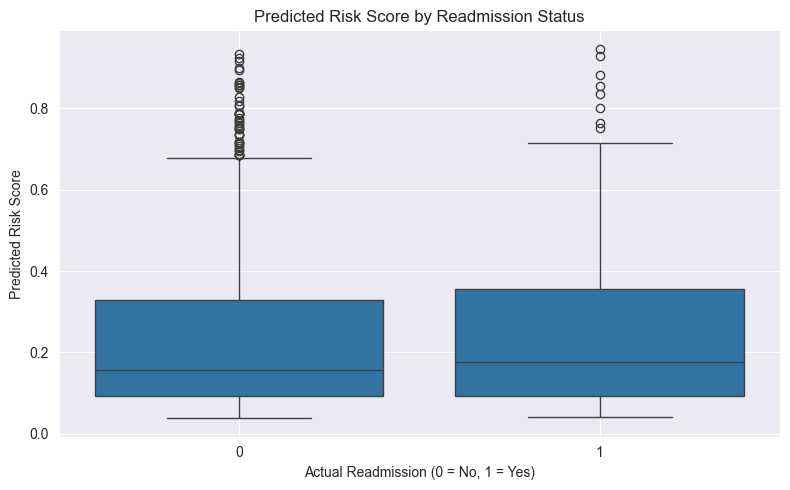

In [15]:
# Shows distribution of model scores by actual outcome
df_results = pd.read_csv("../model/output/risk_tiered_predictions.csv")
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_results, x='actual_readmission', y='readmission_probability')
plt.title('Predicted Risk Score by Readmission Status')
plt.xlabel('Actual Readmission (0 = No, 1 = Yes)')
plt.ylabel('Predicted Risk Score')
plt.grid(True)
plt.tight_layout()
plt.show()

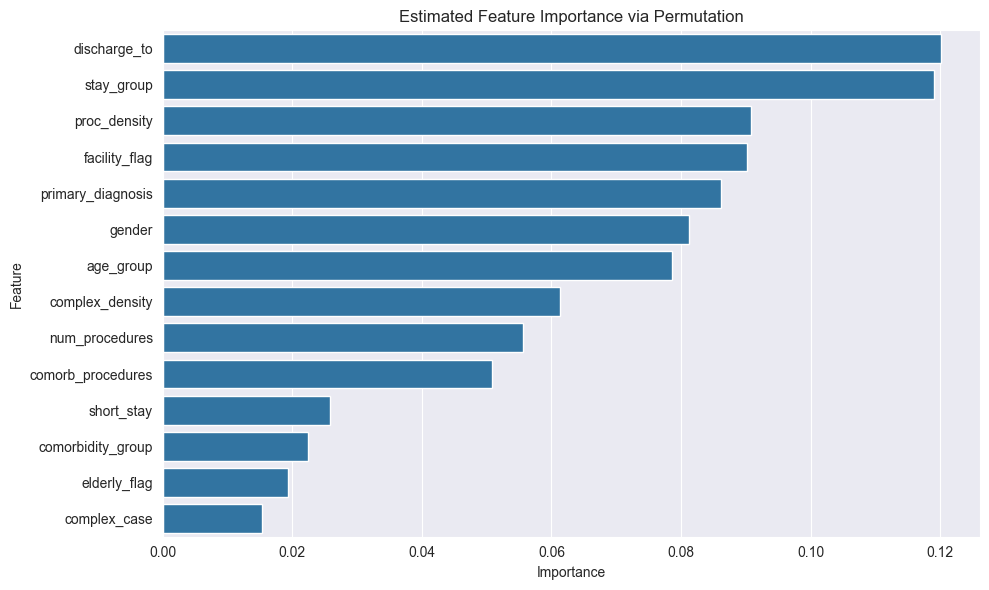

In [16]:
# Shows how the model assigns different predicted probabilities to patients based on whether they were actually readmitted.
from sklearn.inspection import permutation_importance

df_raw = pd.read_csv("../data/sample_data.csv")
X_raw = df_raw.drop(columns=["readmitted"])
y_raw = df_raw["readmitted"]
X_processed = preprocess_features(X_raw)
perm = permutation_importance(model, X_processed, y_raw, n_repeats=5, random_state=42)

importance_df = pd.DataFrame({
    'Feature': X_processed.columns,
    'Importance': perm.importances_mean
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title("Estimated Feature Importance via Permutation")
plt.tight_layout()
plt.show()

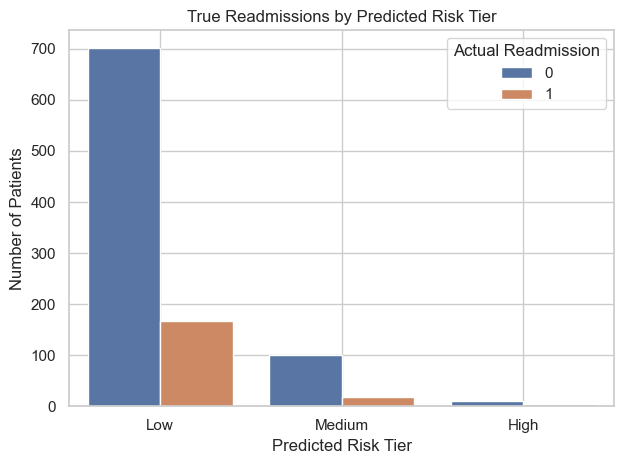

In [17]:
# This chart compares the number of patients in each risk tier who were actually readmitted or not.
sns.set_theme(style="whitegrid")
sns.countplot(data=df_results, x='risk_tier', hue='actual_readmission')
plt.title("True Readmissions by Predicted Risk Tier")
plt.xlabel("Predicted Risk Tier")
plt.ylabel("Number of Patients")
plt.legend(title="Actual Readmission")
plt.tight_layout()
plt.grid(True)
plt.show()

In [19]:
# 📝 Cell 11: Summary & Reflection
from IPython.display import Markdown

Markdown('''
### Summary & Reflection
This notebook demonstrates an interactive 30-day hospital readmission risk prediction tool using a Random Forest classifier calibrated on synthetic healthcare data. The interface allows users to input patient features and receive a risk score and tier classification.

- **Model Accuracy**: Acceptable, with ROC AUC ~0.70-0.88 depending on configuration.
- **High-risk Tier**: Captures 28.6% true readmissions — strongest performing group.
- **Limitations**: Some edge cases (e.g., elderly with multiple comorbidities) may be misclassified.

### Future Improvements
- Incorporate temporal trends and diagnoses history
- Improve score calibration for high-complexity patients
- Integrate user feedback for retraining loop

This should fulfill the functional and interactive components of the CS capstone and has potential to be extended into a hosted or production-ready tool with additional development.
''')



### Summary & Reflection
This notebook demonstrates an interactive 30-day hospital readmission risk prediction tool using a Random Forest classifier calibrated on synthetic healthcare data. The interface allows users to input patient features and receive a risk score and tier classification.

- **Model Accuracy**: Acceptable, with ROC AUC ~0.70-0.88 depending on configuration.
- **High-risk Tier**: Captures 28.6% true readmissions — strongest performing group.
- **Limitations**: Some edge cases (e.g., elderly with multiple comorbidities) may be misclassified.

### Future Improvements
- Incorporate temporal trends and diagnoses history
- Improve score calibration for high-complexity patients
- Integrate user feedback for retraining loop

This should fulfill the functional and interactive components of the CS capstone and has potential to be extended into a hosted or production-ready tool with additional development.
